## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

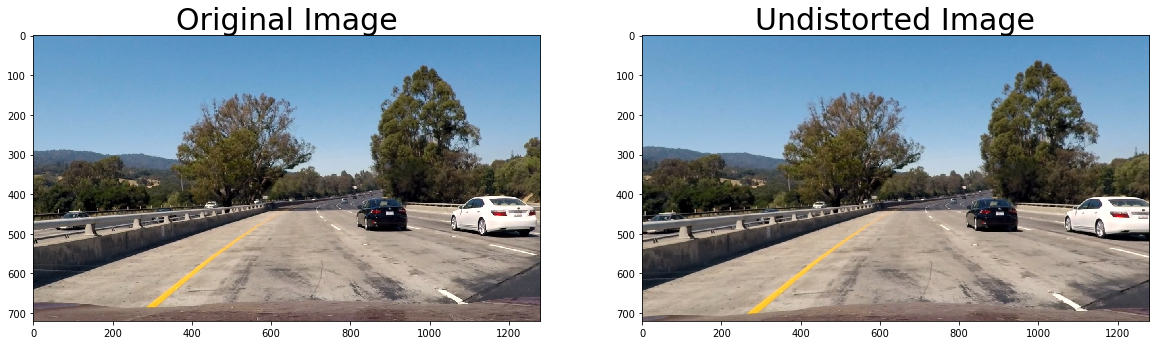

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()
img = plt.imread('../test_images/test1.jpg')
#img = cv2.imread('calibration_wide/test_image.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('../test_images/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "../test_images/wide_dist_pickle.p", "wb" ) )

def undistort(img):
    load_dist_pickle = {}
    with open('../test_images/wide_dist_pickle.p', 'rb') as handle:
        load_dist_pickle = pickle.load(handle)
    undistort = cv2.undistort(img,load_dist_pickle["mtx"],load_dist_pickle["dist"],None,load_dist_pickle["mtx"])
    return undistort

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistort(img))
ax2.set_title('Undistorted Image', fontsize=30)

# Use color transforms, gradients, etc., to create a thresholded binary image.

(720, 1280)


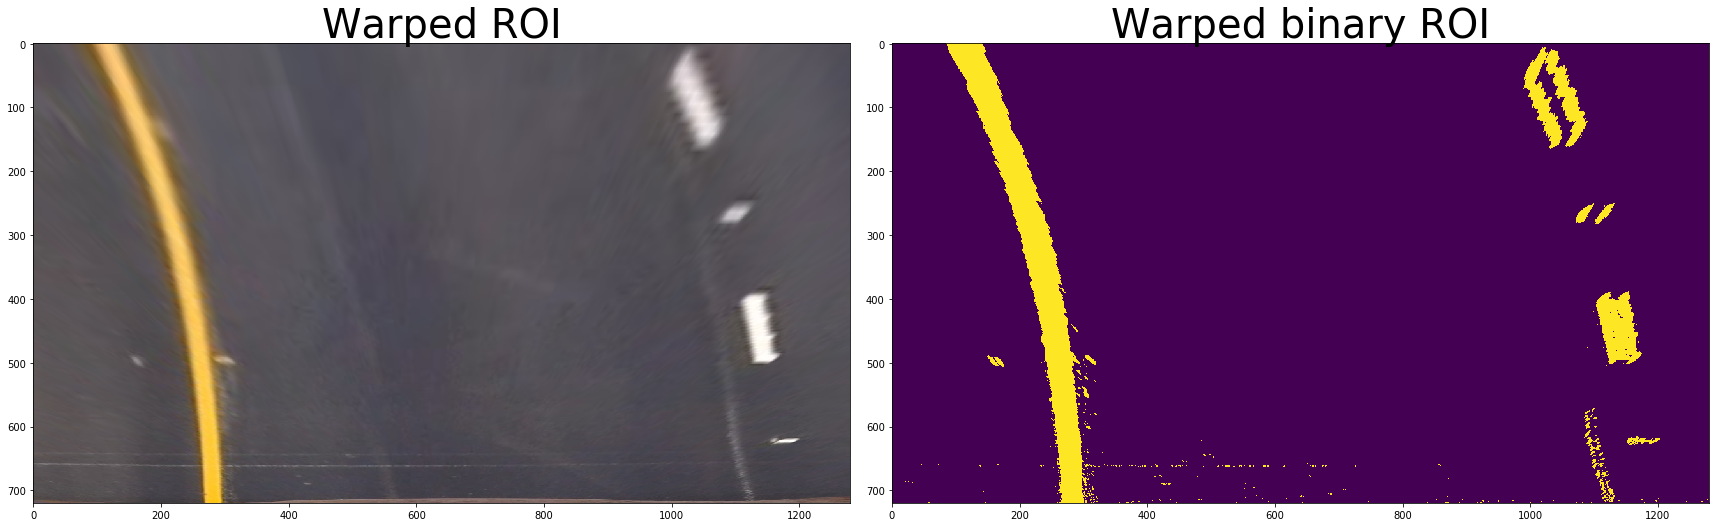

In [134]:
def binarize(img, s_thresh=(120, 255), sx_thresh=(20, 255),l_thresh=(40,255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    # sobelx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255))
    # l_channel_col=np.dstack((l_channel,l_channel, l_channel))
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    channels = 255*np.dstack(( l_binary, sxbinary, s_binary)).astype('uint8')        
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    binary = 255*np.dstack((binary,binary,binary)).astype('uint8')
    return binary,channels

def get_perspective_transform(image, display=False):
    img_size = image.shape
    #corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
    #new_top_left=np.array([corners[0,0],0])
    #new_top_right=np.array([corners[3,0],0])
    #offset=[150,0]
    img_size = (img.shape[1], img.shape[0])
    #src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    #dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])
    src = np.float32([(257, 685), (1050, 685), (583, 460),(702, 460)])
    dst = np.float32([(200, 720), (1080, 720), (200, 0), (1080, 0)])
    warp_m = cv2.getPerspectiveTransform(src, dst)
    warp_minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, warp_m, img_size , flags=cv2.INTER_LINEAR)
    return warped, warp_m

warp_m, warp_minv = get_perspective_transform(dst, display=True)

def warp_pipeline(img):
    undist = undistort(img)    
    result,_ = get_perspective_transform(undist)
    return result
    
def warp_binarize_pipeline(img):
    undist = undistort(img)
    result,_  = get_perspective_transform(undist)
    binary,_  = binarize(result)
    return binary[:,:,0]

img = plt.imread('../test_images/test2.jpg')
warp_roi = warp_pipeline(img)
img = plt.imread('../test_images/test2.jpg')
warp_binary_roi = warp_binarize_pipeline(img)
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warp_roi)
ax1.set_title('Warped ROI', fontsize=40)

ax2.imshow(warp_binary_roi)
ax2.set_title('Warped binary ROI', fontsize=40)
print(warp_binary_roi.shape)

In [135]:
#Detect lane pixels and fit to find the lane boundary.

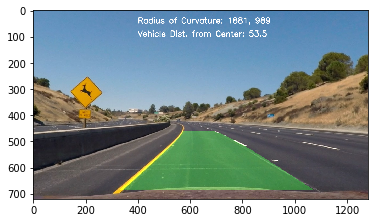

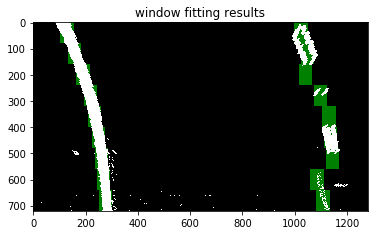

In [136]:
# Read in a thresholded image
warped = warp_binary_roi
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

src = np.float32([(257, 685), (1050, 685), (583, 460),(702, 460)])
dst = np.float32([(200, 720), (1080, 720), (200, 0), (1080, 0)])
M = cv2.getPerspectiveTransform(src, dst) 
Minv = cv2.getPerspectiveTransform(dst, src)


def curvature_radius(trans, left_fit, right_fit):
    y_eval = np.max(trans[0])
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    radi = [left_curverad, right_curverad]
    curvature_string = "Radius of Curvature: " + str(int(radi[0])) + ", " + str(int(radi[1]))
    return curvature_string

def pos_from_center(trans, leftx_base, rightx_base):
    pos = trans.shape[1]/2
    offset = abs(pos - (leftx_base + rightx_base)/2)
    location_string = "Vehicle Distance from Center: " + str(offset)
    return location_string

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    # Add what we found for the first layer
    
    hist = np.sum(image[int(image.shape[0]/2):,:], axis=0) 
    #output image to draw on + visualize
    #peaks of left + right halves if hist	
    midpoint = np.int(hist.shape[0]/2)
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint
        
    window_centroids.append((l_center,r_center))
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
    return window_centroids,leftx_base,rightx_base

window_centroids,leftx_base,rightx_base = find_window_centroids(warped, window_width, window_height, margin)

if len(window_centroids)>0:
    prev_y=720
    for i in window_centroids:
        next_y=prev_y-80
        left_warped = warped[int(i[0]-25):int(i[0]+25),next_y:prev_y]
        x = np.argwhere(left_warped==255)
        prev_y = next_y

# If we found any window centers
good_left_x = []
good_left_y = []
good_right_x = []
good_right_y = []
if len(window_centroids) > 0:
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        l_mask2 = cv2.bitwise_and(warped,warped, mask=l_mask)
        good_l = np.argwhere(l_mask2>0)
        good_l_rev = []
        for k in good_l:
            good_left_x.append(k[0])
            good_left_y.append(k[1])
            good_l_rev.append([k[1],k[0]])
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        r_mask2 = cv2.bitwise_and(warped,warped, mask=r_mask)
        good_r = np.argwhere(r_mask2>0)
        good_r_rev = []
        for k in good_r:
            good_right_x.append(k[0])
            good_right_y.append(k[1])
            good_r_rev.append([k[1],k[0]])
        # Add graphic points from window mask here to total pixels found 
        l_points[ ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

undist = undistort(img)

if len(good_left_x)>0 and len(good_right_x)>0:
    left_fit = np.polyfit(good_left_x, good_left_y, 2)
    right_fit = np.polyfit(good_right_x, good_right_y, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    
    persp_transform_image = warped
    warp_zero = np.zeros_like(persp_transform_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    #Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (persp_transform_image.shape[1], persp_transform_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    curvature_string = curvature_radius(persp_transform_image, left_fit, right_fit)
    location_string = pos_from_center(persp_transform_image, leftx_base, rightx_base)
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    cv2.putText(result,curvature_string,(400,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,location_string,(400,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    #return result
    plt.imshow(result)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    plt.show()


# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


In [ ]:
## Determine the curvature of the lane and vehicle position with respect to center.
